# Part A - TensorFlow

### Prepare data and run model methods

In [0]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

# Disable TF warning messages
tf.logging.set_verbosity(tf.logging.ERROR)


def load_and_prep_data(extract_class=False, class_a=None, class_b=None,
                       one_hot=False):
    """
    Load the data set and prepare for use in the model.

    :param extract_class: (bool) If two classes are to be extracted from data
    :param class_a: (int) The first class
    :param class_b: (int) THe second class
    :param one_hot: (bool) If the class labels are to be one hot encoded
    :return: x_train: (ndarray) The training data feature set
    :return: y_train: (ndarray) The training data class labels
    :return: x_test: (ndarray) The test data feature set
    :return: y_test: (ndarray) The training data class labels
    """
    # Import data
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # If class extraction is enabled...
    if extract_class:
        # Compute bitwise OR on two array conditions where the class matches
        # a or b values provided, this will create one boolean array which can
        # be used for class extraction on training data and another after for
        # the test data
        train_lbl_cond = np.bitwise_or((y_train == class_a),
                                       (y_train == class_b))
        test_lbl_cond = np.bitwise_or((y_test == class_a),
                                      (y_test == class_b))

        # Extract all labels from the training and test using the boolean
        # arrays
        y_train = y_train[train_lbl_cond]
        y_test = y_test[test_lbl_cond]

        # Extract all rows from the training and test data using the boolean
        # arrays, or each selected row select all the columns
        x_train = x_train[train_lbl_cond, :]
        x_test = x_test[test_lbl_cond, :]

        # Convert the classes from 3 and 8 to 0 and 1 by creating a boolean
        # array where it is True is the value matches 8, otherwise False.
        # Converting this using astype(int) replaces the True/False values with
        # 0/1 respectively
        y_train = (y_train == class_b).astype('float32')
        y_test = (y_test == class_b).astype('float32')
        y_train = y_train.reshape(1, -1)
        y_test = y_test.reshape(1, -1)

    # Else if one hot encoding is enabled...
    elif one_hot:
        # Convert labels to one-hot-encoded
        number_of_classes = 10
        y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
        y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

        # Transpose train labels so that dimensions
        # are number of classes * number of instances
        y_train = y_train.T
        y_test = y_test.T

    # Reshape the training and test data and normalize
    x_train = x_train.reshape(x_train.shape[0], -1).astype(
        'float32')
    x_test = x_test.reshape(x_test.shape[0], -1).astype('float32')
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Transpose the training and test data
    x_train = x_train.T
    x_test = x_test.T

    return x_train, y_train, x_test, y_test


def run_model(x_train, y_train, x_test, y_test, x, y, optimizer, accuracy,
              loss, n_epochs=1, show_chart=False, batch_size=0):
    """
    Run the Tensor Flow session on a given computational graph.

    :param x_train: (ndarray) The training data feature set
    :param y_train: (ndarray) The training data class labels
    :param x_test: (ndarray) The test data feature set
    :param y_test: (ndarray) The training data class labels
    :param x: (tf-placeholder) Placeholder for training feature data
    :param y: (tf-placeholder) Placeholder for training class labels
    :param optimizer: (tf-node) The model optimizer
    :param accuracy: (tf-node) The model accuracy
    :param loss: (tf-node) The model loss
    :param n_epochs: (int) The number of epochs to run, default 1
    :param show_chart: (bool) If the results should be output to charts
    :param batch_size: (int) The batch size, default 0 for full data set use
    """
    # Start training
    with tf.Session() as sess:
        # Initialise session results lists
        train_loss_results = list()
        train_accuracy_results = list()
        test_loss_results = list()
        test_accuracy_results = list()
        # Set display step for output of epoch progression
        display_step = 5
        # Initialise global variables
        sess.run(tf.global_variables_initializer())
        # Start timer
        start_time = time.time()
        # For the range of epochs set...
        for i in range(1, n_epochs + 1):
            # If the batch set has been changed from default all...
            if batch_size > 0:
                # Calculate the amount of batches required
                n_batches = int(train_imgs.shape[0] / batch_size)
                # If there is data left over, increment batch count by 1 to get
                # remaining data
                if x_train.shape[0] % batch_size > 0:
                    n_batches += 1
                # For the range of batches required to process all data...
                for n in range(batch_size):
                    # Set the column index for current batch slice, use all
                    # rows from column
                    mini_feed_train = ({
                        x: x_train[:, i * batch_size:(i + 1) * batch_size],
                        y: y_train[:, i * batch_size:(i + 1) * batch_size]})
                    # Run the training session
                    _, current_loss, acc = sess.run(
                        [optimizer, loss, accuracy], feed_dict=mini_feed_train)

            # Else no batch set, default to all...
            else:
                # Set the session training feature and class label data sets
                feed_train = {x: x_train, y: y_train}
                # Run the training session
                _, current_loss, acc = sess.run([optimizer, loss, accuracy],
                                                feed_dict=feed_train)
            # Append the training epoch loss and accuracy results to the
            # session dicts
            train_loss_results.append(current_loss)
            train_accuracy_results.append(acc)

            # Set the session test feature and class label data sets
            feed_test = {x: x_test, y: y_test}
            # Run the test session
            _, test_loss, test_acc = sess.run([optimizer, loss, accuracy],
                                              feed_dict=feed_test)
            # Append the training epoch loss and accuracy results to the
            # session dicts
            test_loss_results.append(test_loss)
            test_accuracy_results.append(test_acc)

            if i % display_step == 0 or i == 1:
                print("TRAINING: \tIteration: {} \tLoss: {} "
                      "\tAccuracy: {}".format(i, current_loss, acc))

                print("TEST: \t\tIteration: {} \tLoss: {} "
                      "\tAccuracy: {}".format(i, test_loss, test_acc))

        print("Training duration: {}s".format(time.time() - start_time))

        # If show chart is enabled...
        if show_chart:
            fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
            fig.suptitle('Training Metrics')

            axes[0].set_ylabel("Loss", fontsize=14)
            axes[0].plot(train_loss_results)

            axes[1].set_ylabel("Accuracy", fontsize=14)
            axes[1].set_xlabel("Epoch", fontsize=14)
            axes[1].plot(train_accuracy_results)

            plt.show()

            plt.style.use('ggplot')
            plt.figure()
            plt.plot(train_accuracy_results, label="Training Acc")
            plt.plot(test_accuracy_results, label="Test Acc")
            plt.title("Training vs Test Accuracy")
            plt.ylabel("Accuracy")
            plt.xlabel("Epoch")
            plt.legend()
            plt.show()

### Build the graph required for part i

In [0]:
def build_graph_1(n_inputs, n_hidden, learning_rate, n_outputs=1):
    """
    Build a computational graph using:
        -Layer 1: 100 neurons (ReLu activation function)
        -Layer 2: 1 neuron (Sigmoid activation function)
        -Learning Rate: 0.01 with Gradient Descent

    :param n_inputs: (int) The number of features being input into the graph
    :param n_hidden: (int) The number of nodes in the first hidden layer
    :param learning_rate: (float) The learning rate
    :param n_outputs: (int) The amount of outputs from the graph, default 1
    :return x: (tf-placeholder) Placeholder for training feature data
    :return y: (tf-placeholder) Placeholder for training class labels
    :return optimizer: (tf-node) The model optimizer
    :return accuracy: (tf-node) The model accuracy
    :return loss: (tf-node) The model loss
    """
    # Reset the graph
    tf.reset_default_graph()
    # Create placeholders for training and label data
    x = tf.placeholder(tf.float32, [n_inputs, None], name='image')
    y = tf.placeholder(tf.int32, [n_outputs, None], name='label')

    # Create weight and bias matrices for the two layers of our network
    w1 = tf.get_variable(
        "w1", [n_hidden, n_inputs],
        initializer=tf.glorot_uniform_initializer(seed=1))
    b1 = tf.get_variable("b1", [n_hidden, 1],
                         initializer=tf.zeros_initializer())

    w2 = tf.get_variable(
        "w2", [n_outputs, n_hidden],
        initializer=tf.glorot_uniform_initializer(seed=1))
    b2 = tf.get_variable("b2", [1, 1],
                         initializer=tf.zeros_initializer())

    # Push feature data through first layer of NN
    a1 = tf.add(tf.matmul(w1, x), b1)
    h1 = tf.nn.relu(a1)

    # Calculate preactivation value for second layer
    a2 = tf.add(tf.matmul(w2, h1), b2)

    # Pipe the results through the sigmoid activation function.
    y_pred_sigmoid = tf.sigmoid(a2)

    y = tf.cast(y, tf.float32)

    # Calculate the cross entropy error for all training data
    x_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=a2, labels=y)

    # Calculate the mean cross entropy error
    loss = tf.reduce_mean(x_entropy)

    # add gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Round the predictions by the logistical unit to either 1 or 0
    predictions = tf.round(y_pred_sigmoid)

    # tf.equal will return a boolean array: True if prediction correct, False
    # otherwise tf.cast converts the resulting boolean array to a numerical
    # array, 1 if True (correct prediction), 0 if False (incorrect prediction)
    predictions_correct = tf.cast(tf.equal(predictions, y), tf.float32)

    # Finally, we just determine the mean value of predictions_correct
    accuracy = tf.reduce_mean(predictions_correct)

    return x, y, optimizer, accuracy, loss

### Build graph required for parts ii & iii

In [0]:
def build_graph_2(n_inputs, n_layer_one, n_layer_two, learning_rate,
                  n_outputs=10):
    """
    Build a computational graph using:
        -Layer 1: 300 neurons (ReLu activation function)
        -Layer 2: 100 neurons (ReLu activation function)
        -Layer 3: Softmax Layer
        -Learning Rate: 0.01 with Gradient Descent

    :param n_inputs: (int) The number of features being input into the graph
    :param n_layer_one: (int) The number of nodes in the first layer
    :param n_layer_two: (int) The number of nodes in the second layer
    :param learning_rate: (float) The learning rate
    :param n_outputs: (int) The amount of outputs from the graph, default 10
    :return x: (tf-placeholder) Placeholder for training feature data
    :return y: (tf-placeholder) Placeholder for training class labels
    :return optimizer: (tf-node) The model optimizer
    :return accuracy: (tf-node) The model accuracy
    :return loss: (tf-node) The model loss
    """
    # Reset the graph
    tf.reset_default_graph()
    # Placeholders for the traing and label data
    x = tf.placeholder(tf.float32, [n_inputs, None], name='image')
    y = tf.placeholder(tf.int32, [n_outputs, None], name='label')

    # Create weight and bias matrices (variables) for each layer of our network
    w1 = tf.get_variable("w1", [n_layer_one, n_inputs],
                         initializer=tf.glorot_uniform_initializer(seed=1))
    b1 = tf.get_variable("b1", [n_layer_one, 1],
                         initializer=tf.zeros_initializer())

    w2 = tf.get_variable("w2", [n_layer_two, n_layer_one],
                         initializer=tf.glorot_uniform_initializer(seed=1))
    b2 = tf.get_variable("b2", [n_layer_two, 1],
                         initializer=tf.zeros_initializer())

    w3 = tf.get_variable("w3", [n_outputs, n_layer_two],
                         initializer=tf.glorot_uniform_initializer(seed=1))
    b3 = tf.get_variable("b3", [n_outputs, 1],
                         initializer=tf.zeros_initializer())

    # Push feature data through first layer of NN
    a1 = tf.add(tf.matmul(w1, x), b1)
    h1 = tf.nn.relu(a1)

    # Calculate preactivation value for second layer
    a2 = tf.add(tf.matmul(w2, h1), b2)
    h2 = tf.nn.relu(a2)

    # Calculate preactivation value for third layer
    a3 = tf.add(tf.matmul(w3, h2), b3)

    # Revert back to shape number of instances * number of classes
    logits = tf.transpose(a3)
    labels = tf.transpose(y)

    # calculate the cross entropy error for each training example
    error = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                       labels=labels)
    loss = tf.reduce_mean(error)

    # Point our gradient descent solver at the loss node
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(a3), tf.argmax(y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    return x, y, optimizer, accuracy, loss

### Load in the data

In [0]:
# Load in the data with class extraction enabled
train_imgs, train_lbls, test_imgs, test_lbls = load_and_prep_data(one_hot=True)

# Load in the data with class extraction enabled
ex_train_imgs, ex_train_lbls, ex_test_imgs, ex_test_lbls = load_and_prep_data(
    extract_class=True, class_a=3, class_b=8)

### Run Pt i

In [5]:
# Build the graph for part 1
ph_x, ph_y, pt1_optimizer, pt1_accuracy, p1_loss = (
    build_graph_1(n_inputs=784, n_hidden=300, learning_rate=0.01))

# Run the model for the graph built in the previous step
run_model(ex_train_imgs, ex_train_lbls, ex_test_imgs, ex_test_lbls, ph_x, ph_y,
          pt1_optimizer, pt1_accuracy, p1_loss)

TRAINING: 	Iteration: 1 	Loss: 0.794786810874939 	Accuracy: 0.4779166579246521
TEST: 		Iteration: 1 	Loss: 0.7114139795303345 	Accuracy: 0.47749999165534973
Training duration: 0.4202868938446045s


### Run Pt ii

TRAINING: 	Iteration: 1 	Loss: 2.421278476715088 	Accuracy: 0.037700001150369644
TEST: 		Iteration: 1 	Loss: 2.3754918575286865 	Accuracy: 0.055399999022483826
TRAINING: 	Iteration: 5 	Loss: 2.1634037494659424 	Accuracy: 0.21231666207313538
TEST: 		Iteration: 5 	Loss: 2.14262318611145 	Accuracy: 0.22869999706745148
TRAINING: 	Iteration: 10 	Loss: 1.9843554496765137 	Accuracy: 0.3445333242416382
TEST: 		Iteration: 10 	Loss: 1.9706828594207764 	Accuracy: 0.3490000069141388
TRAINING: 	Iteration: 15 	Loss: 1.8433438539505005 	Accuracy: 0.4408000111579895
TEST: 		Iteration: 15 	Loss: 1.8334554433822632 	Accuracy: 0.4440000057220459
TRAINING: 	Iteration: 20 	Loss: 1.7224476337432861 	Accuracy: 0.5103499889373779
TEST: 		Iteration: 20 	Loss: 1.7153592109680176 	Accuracy: 0.5105999708175659
TRAINING: 	Iteration: 25 	Loss: 1.6168137788772583 	Accuracy: 0.559249997138977
TEST: 		Iteration: 25 	Loss: 1.6118546724319458 	Accuracy: 0.5559999942779541
TRAINING: 	Iteration: 30 	Loss: 1.52410221099853

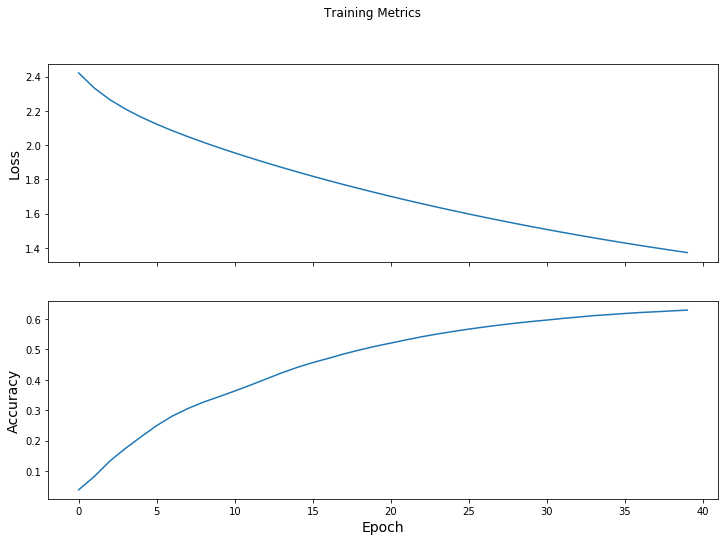

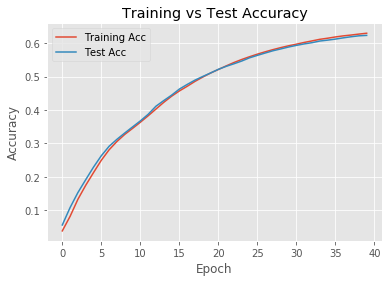

In [8]:
# # Build the graph for part 2
ph_x, ph_y, pt1_optimizer, pt1_accuracy, p1_loss = (
    build_graph_2(n_inputs=784, n_layer_one=300, n_layer_two=100,
                  learning_rate=0.01))

# # Run the model for the graph built in the previous step
run_model(train_imgs, train_lbls, test_imgs, test_lbls, ph_x, ph_y,
          pt1_optimizer, pt1_accuracy, p1_loss, n_epochs=40, show_chart=True)

### Run Pt iii

TRAINING: 	Iteration: 1 	Loss: 0.6982564330101013 	Accuracy: 0.859375
TEST: 		Iteration: 1 	Loss: 0.9144496917724609 	Accuracy: 0.6973000168800354
TRAINING: 	Iteration: 5 	Loss: 0.33226391673088074 	Accuracy: 0.91015625
TEST: 		Iteration: 5 	Loss: 0.6029135584831238 	Accuracy: 0.788100004196167
TRAINING: 	Iteration: 10 	Loss: 0.2589729428291321 	Accuracy: 0.9453125
TEST: 		Iteration: 10 	Loss: 0.5673747062683105 	Accuracy: 0.7997000217437744
TRAINING: 	Iteration: 15 	Loss: 0.26927924156188965 	Accuracy: 0.9296875
TEST: 		Iteration: 15 	Loss: 0.576745331287384 	Accuracy: 0.8040000200271606
TRAINING: 	Iteration: 20 	Loss: 0.20614272356033325 	Accuracy: 0.9609375
TEST: 		Iteration: 20 	Loss: 0.5650736689567566 	Accuracy: 0.815500020980835
TRAINING: 	Iteration: 25 	Loss: 0.15032963454723358 	Accuracy: 0.9765625
TEST: 		Iteration: 25 	Loss: 0.5659563541412354 	Accuracy: 0.8242999911308289
TRAINING: 	Iteration: 30 	Loss: 0.1318448781967163 	Accuracy: 0.98046875
TEST: 		Iteration: 30 	Loss: 0

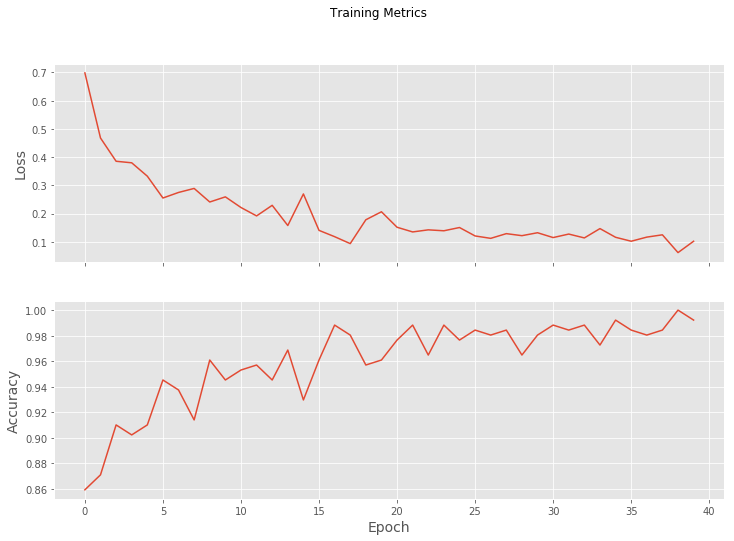

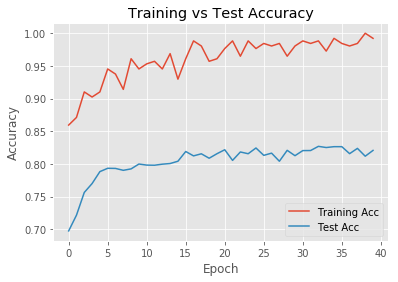

In [9]:
# Run the model for the graph built in the previous step but this time use mini
# batch
run_model(train_imgs, train_lbls, test_imgs, test_lbls, ph_x, ph_y,
          pt1_optimizer, pt1_accuracy, p1_loss, n_epochs=40, show_chart=True,
          batch_size=256)